In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import mean_squared_error

# LSTM FORECASTING SETUP

Defining methods to set up data to return sequences of varying lengths (n_steps) for x and y:


We also plan to try to clean up the data more exhaustively.

In [4]:
LSTMData = pd.read_csv("/home/jik19004/FilesToRun/DINGRESEARCH/DingResearchDec28th/LSTMFolder/FINALIZED_DATA.csv")
display(LSTMData)

,Demand,Annual Usage (kWh),Year,Month,Day,Hour,WeekDay or Weekend,HVN_lon,HVN_lat,HVN_tmpf,...,DXR_drct,DXR_sknt,DXR_vsby,MMK_lon,MMK_lat,MMK_tmpf,MMK_drct,MMK_sknt,MMK_vsby,HotTemperatures
0,3053.00,13244.454545,2011,1,1,0,0,-72.8868,41.2638,33.980000,...,0.000000,0.000000,5.000000,-72.83,41.51,28.94,0.0,0.0,4.0,0
1,2892.00,13244.454545,2011,1,1,1,0,-72.8868,41.2638,37.940000,...,0.000000,0.000000,5.000000,-72.83,41.51,28.94,0.0,0.0,4.0,0
2,2774.00,13244.454545,2011,1,1,2,0,-72.8868,41.2638,37.040000,...,0.000000,0.000000,4.000000,-72.83,41.51,33.08,150.0,5.0,5.0,0
3,2710.00,13244.454545,2011,1,1,3,0,-72.8868,41.2638,33.980000,...,0.000000,0.000000,4.000000,-72.83,41.51,33.08,150.0,4.0,6.0,0
4,2698.00,13244.454545,2011,1,1,4,0,-72.8868,41.2638,30.920000,...,0.000000,0.000000,4.000000,-72.83,41.51,28.94,100.0,3.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96422,3310.60,14064.500000,2021,12,31,19,1,-72.8868,41.2638,46.133333,...,46.666667,1.333333,6.666667,-72.83,41.51,43.00,0.0,0.0,4.0,0
96423,3148.00,14064.500000,2021,12,31,20,1,-72.8868,41.2638,46.133333,...,46.666667,1.333333,6.666667,-72.83,41.51,43.00,0.0,0.0,4.0,0
96424,2988.93,14064.500000,2021,12,31,21,1,-72.8868,41.2638,46.133333,...,46.666667,1.333333,6.666667,-72.83,41.51,43.00,0.0,0.0,4.0,0
96425,2793.70,14064.500000,2021,12,31,22,1,-72.8868,41.2638,46.133333,...,46.666667,1.333333,6.666667,-72.83,41.51,43.00,0.0,0.0,4.0,0


# Splitting the Data into Training, Validation, and Testing! 

In [5]:
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameter 
import tensorflow as tf 
from tensorflow import keras as keras 

from tensorflow.python.client import device_lib
def get_available_devices():
     local_device_protos = device_lib.list_local_devices()
     return [x.name for x in local_device_protos]
print(get_available_devices())

['/device:CPU:0']


2024-01-07 13:54:58.784837: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


FOR LSTM Use previous data strictly to predict time t. 
Example: t-5,t-4,t-3,t-2,t-1 to predict the t time. 
This makes sense logically because at time t, you will obtain the values on that day but we want to predict ahead of time! 

In [6]:
DemandData = LSTMData.loc[:,"Demand"].copy()
def return_sequences(data, outputData, input_n_steps, output_n_steps):
    X = []
    Y = []
    length = len(data)
    for i in range(0,length, 1):
        input_indx = i + input_n_steps
        output_indx = input_indx + output_n_steps 
        if (output_indx > len(data)): # we need to have equally split sequences. 
            break               # The remaining data that cannot fit into a fixed
                                # sequence will immediately be cut!
        else:
            Xsample = data.iloc[i:input_indx, :] # get the previous data
            Ysample = outputData[input_indx:output_indx]
            X.append(Xsample)
            Y.append(Ysample) 
    X = np.asarray(X).astype('float64')
    Y = np.asarray(Y).astype('float64')
    return (X, Y)


In [7]:
from sklearn.preprocessing import StandardScaler 
def scaleTheData(data):
    scaler = StandardScaler()
    # split the data first. 
    data2 = scaler.fit_transform(data)
    data = pd.DataFrame(data2, columns = data.columns)
    return data

def splitDataAndScale(data, output):    
    TrainingData = scaleTheData(data.iloc[:61363, :].copy()) # The index for Janruary 1st basically, don't necessarily hard code it. 
    # Janruary 1st 2018. 
    TrainingOutput = output[:61363].copy()

    RemainingData = data.iloc[61363:, :].copy()
    RemainingOutput = output[61363:].copy()

    ValidationData = scaleTheData(RemainingData.iloc[:int(0.5*len(RemainingData)), :].copy())
    ValidationOutput = RemainingOutput[:int(0.5*len(RemainingOutput))].copy()

    TestingData = scaleTheData(RemainingData.iloc[int(0.5 * len(RemainingData)):, :].copy())
    TestingOutput = RemainingOutput[int(0.5 * len(RemainingData)):].copy()


    TrainingSequences = return_sequences(TrainingData, TrainingOutput, 18, 1) 

    TransformedTrainingData = TrainingSequences[0]
    TransformedTrainingOutput = TrainingSequences[1]

    ValidationSequences = return_sequences(ValidationData, ValidationOutput, 18, 1)

    TransformedValidationData = ValidationSequences[0]
    TransformedValidationOutput = ValidationSequences[1]

    TestingSequences = return_sequences(TestingData, TestingOutput, 18, 1)

    TransformedTestingData = TestingSequences[0]
    TransformedTestingOutput = TestingSequences[1]



    return (TransformedTrainingData, TransformedTrainingOutput, TransformedValidationData, TransformedValidationOutput, 
    TransformedTestingData, TransformedTestingOutput)
    
    

In [8]:
data = splitDataAndScale(LSTMData, DemandData)

# LSTM Model Construction 

In [9]:
import torch 
class LSTMModel(torch.nn.Module):
    def __init__(self, alpha, num_layers, lastNeurons, LSTMNeurons, params, output_num =1):
        super(LSTMModel, self).__init__()
        self.LSTM1 = torch.nn.LSTM(input_size = 56, hidden_size = LSTMNeurons, num_layers = 1, bias = True, batch_first = True)
        self.LSTM2 = torch.nn.LSTM(input_size = LSTMNeurons, hidden_size = LSTMNeurons, num_layers = 1, bias = True, batch_first = True, bidirectional = False)
        self.batchNorm0 = torch.nn.BatchNorm1d(num_features = 18)
        
        input_size = LSTMNeurons
        layers = [] 
        for i in range(num_layers):
            num_units = params[i]
            layers.append(torch.nn.Linear(input_size, num_units, bias = True))
            layers.append(torch.nn.LeakyReLU(negative_slope = 0.25))
            layers.append(torch.nn.BatchNorm1d(num_features = 18))
            layers.append(torch.nn.Dropout(0.35))
            input_size = num_units
        self.intermediateLayers = torch.nn.Sequential(*layers)
        self.Linear1 = torch.nn.Linear(in_features = input_size, out_features = lastNeurons, bias = True)
        self.Activation1 = torch.nn.LeakyReLU(negative_slope = 0.25)
        self.Dropout = torch.nn.Dropout(0.35)
        
        
        self.Linear2 = torch.nn.Linear(in_features = lastNeurons * 18, out_features = output_num, bias = True)

        
        
        
    def forward(self, val):
        
        x = self.LSTM1(val)
        x = self.LSTM2(x[0], (x[1][0],x[1][1])) #(x[1][0], x[1][1])
        x = self.LSTM2(x[0])
        x = self.batchNorm0(x[0])
        
        x = self.intermediateLayers(x)
        x = self.Linear1(x)
        x = self.Activation1(x)
        x = self.Dropout(x)
        x = x.view(-1, x.size(1) * x.size(2))        
        
        x = self.Linear2(x)
        
        return x
        

In [10]:
import optuna 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class TimeSeriesDataset(Dataset):
    def __init__(self, data, output):
        data = torch.tensor(data).float(); 
        output = torch.tensor(output).float() 
        self.data = data 
        self.output = output; 

    def __len__(self):
        return len(self.data) 

    def __getitem__(self, idx):
        x = self.data[idx];  
        y = self.output[idx]; 
        
        return x, y; 

# use the past 72 hours in advance and then predict the 1st hour, 6th hour, 12 hours! 

def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target)
            running_loss += loss.item() * target.size(0)
    return running_loss / len(val_loader.dataset)

def Train_and_Evaluate(train_loader, val_loader, device, params1, params2, numEpochs, early_stop_epochs):
    #num_layers, dropout = 0.1, outfeatures1 = 16, outfeatures2 = 16, outfeatures3 = 16, outfeatures4 = 16, dim_feedforward = 2048, output_num = 1
    model = LSTMModel(alpha = params1[0], num_layers = params1[1], lastNeurons= params1[2], LSTMNeurons = params1[3], params = params2)
    model = model.to(device);
    LossFunction = torch.nn.L1Loss();
    best_val_loss = float('inf')
    early_stop_count = 0
   
    
    Optimizer = torch.optim.Adam(params = model.parameters(), weight_decay = 0.001)
    for epoch in range(0,numEpochs):
        model.train() 
        Training_Loss = 0; 
        total_samples = 0; 
        for input, output in train_loader:
            input = input.to(device); 
            output = torch.squeeze(output, 1); 
            output = output.to(device); 
            predictedVal = model(input)
            predictedVal = torch.squeeze(predictedVal, 1)
            Optimizer.zero_grad();
            batchLoss = LossFunction(predictedVal, output);
            batchLoss.backward(); 
            Optimizer.step();
            Training_Loss += batchLoss * output.size(0) #* output.size(0);
            total_samples += output.size(0)
        Training_Loss = Training_Loss.item()/total_samples


        Validation_Loss = 0; 
        print("passed ", epoch, "epoch", "Training Loss: ", Training_Loss," ", end = "")
        with torch.no_grad():
            model.eval()
            total_val_samples = 0; 
            Validation_Loss = 0; 
            for val_input, val_output in val_loader:
                val_input = val_input.to(device); 
                val_output = torch.squeeze(val_output,1);
                val_output = val_output.to(device);
                predictedVal = model(val_input)
                predictedVal = torch.squeeze(predictedVal, 1)
                Validation_Loss += LossFunction(val_output, predictedVal) * val_output.size(0)
                total_val_samples += val_output.size(0)
            Validation_Loss = Validation_Loss/total_val_samples
            print("Validation Loss: ", Validation_Loss)

            if Validation_Loss < best_val_loss:
                best_val_loss = Validation_Loss
                torch.save(model, "//home//jik19004//FilesToRun//DINGRESEARCH//DingResearchDec28th//LSTMFolder//LSTM1")
                early_stop_count = 0;
            else:
                early_stop_count +=1 
            if early_stop_count >= early_stop_epochs:
                return best_val_loss; 

    return best_val_loss; 

def predict(model, data_loader, device):
    model.eval()
    predictions = []
    act_outputs = []
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            output = model(data)
            predictions.append(output.cpu().numpy())
            act_outputs.append(_.numpy())

    return (np.concatenate(predictions), np.concatenate(act_outputs))
    

In [11]:
TrainingData = TimeSeriesDataset(data[0],data[1]);
TrainingLoader = DataLoader(TrainingData, batch_size = 128);


ValidationData = TimeSeriesDataset(data[2],data[3]);
ValidationLoader = DataLoader(ValidationData, batch_size = 128);


TestingData = TimeSeriesDataset(data[4],data[5]);
TestingLoader = DataLoader(TestingData, batch_size = 256);

In [12]:
def objective(trial):
    #num_layers = params[0], outfeatures = params[1], dim_feedforward = params[2]
    params1 = [trial.suggest_float("alpha", low = 0.2, high = 0.25, log=True), 
              trial.suggest_int("num_layers", low = 2, high = 4, step = 1),
              trial.suggest_int("last_hidden_neurons", low = 42, high = 90, step = 16),
              trial.suggest_int("LSTM_neurons", low = 72, high = 88, step = 8)]
    
    params2 = [trial.suggest_int("num_hiddenZero", low = 74, high = 138, step = 16),
               trial.suggest_int("num_hiddenOne", low = 106, high = 180, step = 16),
               trial.suggest_int("num_hiddenTwo", low = 58, high = 122, step = 16),
               trial.suggest_int("num_hiddenThree", low = 58, high = 106, step = 16)]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
    return Train_and_Evaluate(TrainingLoader, ValidationLoader, device, params1, params2, 260, 20); 

import joblib 
study_name = 'sqlite:///LSTMOutput1.db'
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), study_name = "NewLSTM1", load_if_exists= True, storage='sqlite:///LSTMOutput1.db')
joblib.dump(study, "LSTMOutput1.pkl")
study.optimize(objective, n_trials = 160)

[I 2024-01-07 13:55:06,888] Using an existing study with name 'NewLSTM1' instead of creating a new one.
/home/jik19004/anaconda3/lib/python3.9/site-packages/optuna/distributions.py:716: UserWarning: The distribution is specified by [106, 180] and step=16, but the range is not divisible by `step`. It will be replaced by [106, 170].
  warnings.warn(
[W 2024-01-07 13:55:12,453] Trial 2 failed with parameters: {'alpha': 0.22230319441375798, 'num_layers': 2, 'last_hidden_neurons': 58, 'LSTM_neurons': 72, 'num_hiddenZero': 106, 'num_hiddenOne': 122, 'num_hiddenTwo': 90, 'num_hiddenThree': 58} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/jik19004/anaconda3/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_28311/2484854889.py", line 13, in objective
    return Train_and_Evaluate(TrainingLoader, ValidationLoader, device, params1, params2, 260, 20);
  Fi

KeyboardInterrupt: 

In [13]:
print(study.best_params)
print(study.best_value)

ValueError: Record does not exist.

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torchmetrics import MeanAbsolutePercentageError
Model1 = torch.load("/home/jik19004/FilesToRun/DINGRESEARCH/DingResearchDec28th/LSTMFolder/bestModels/LSTM1")
predictions = predict(Model1, TestingLoader, device = torch.device("cuda"))
MAE_result = mean_absolute_error(predictions[0], predictions[1])
MSE_result = mean_squared_error(predictions[0], predictions[1])
MAPE = MeanAbsolutePercentageError()
MAPE_result = MAPE(torch.Tensor(predictions[0]), torch.Tensor(predictions[1]))
print("MSE for Testing: ", MSE_result)
print("MAE for Testing: ", MAE_result)
print("MAPE for Testing: ", MAPE_result)


MSE for Testing:  28925.322
MAE for Testing:  156.692
MAPE for Testing:  tensor(0.0525)


In [15]:
print(Model1)

LSTMModel(
  (LSTM1): LSTM(56, 88, batch_first=True)
  (LSTM2): LSTM(88, 88, batch_first=True)
  (batchNorm0): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (intermediateLayers): Sequential(
    (0): Linear(in_features=88, out_features=90, bias=True)
    (1): LeakyReLU(negative_slope=0.25)
    (2): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.35, inplace=False)
    (4): Linear(in_features=90, out_features=154, bias=True)
    (5): LeakyReLU(negative_slope=0.25)
    (6): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.35, inplace=False)
  )
  (Linear1): Linear(in_features=154, out_features=42, bias=True)
  (Activation1): LeakyReLU(negative_slope=0.25)
  (Dropout): Dropout(p=0.35, inplace=False)
  (Linear2): Linear(in_features=756, out_features=1, bias=True)
)


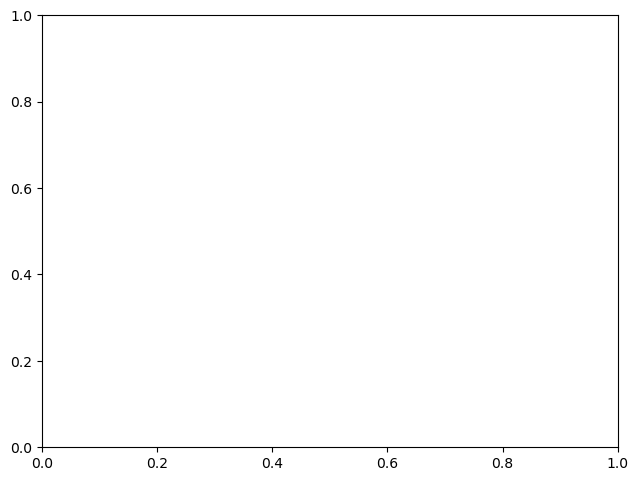

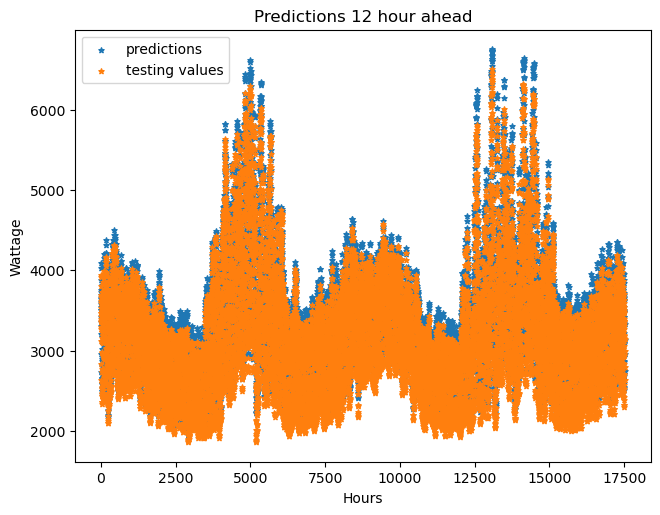

In [16]:
import matplotlib.pyplot as plt 

fig = plt.figure() 

axes = fig.add_axes([0.1, 0.1, 0.9, 0.9])
predictionsAdjusted = []
prediction = predictions[0]

for i in prediction:
    for j in i: 
        predictionsAdjusted.append(j)

fig = plt.figure() 
Hours = [i for i in range(len(data[4]))]

axes = fig.add_axes([0.1, 0.1, 0.9, 0.9])
axes.scatter(Hours, predictionsAdjusted, label = "predictions", s = 15,  marker = "*")
testingValuesAdjusted = [] 


for i in predictions[1]: # getting the actual testing values. 
    for j in i: 
        testingValuesAdjusted.append(j)
axes.scatter(Hours, testingValuesAdjusted, label = "testing values",s =  15,  marker = "*")
axes.set_xlabel("Hours")
axes.set_ylabel("Wattage")
plt.title("Predictions 12 hour ahead")
axes.legend() 

# Calculate the MAE for Work Day and Weekend Days! 

In [ ]:
display(LSTMData)

,Annual Usage (kWh),Year,Month,Day,Hour,WeekDay or Weekend,HVN_lon,HVN_lat,HVN_tmpf,HVN_drct,...,DXR_drct,DXR_sknt,DXR_vsby,MMK_lon,MMK_lat,MMK_tmpf,MMK_drct,MMK_sknt,MMK_vsby,HotTemperatures
0,13244.454545,2011,1,1,0,0,-72.8868,41.2638,33.980000,190.000000,...,0.000000,0.000000,5.000000,-72.83,41.51,28.94,0.0,0.0,4.0,0
1,13244.454545,2011,1,1,1,0,-72.8868,41.2638,37.940000,63.333333,...,0.000000,0.000000,5.000000,-72.83,41.51,28.94,0.0,0.0,4.0,0
2,13244.454545,2011,1,1,2,0,-72.8868,41.2638,37.040000,200.000000,...,0.000000,0.000000,4.000000,-72.83,41.51,33.08,150.0,5.0,5.0,0
3,13244.454545,2011,1,1,3,0,-72.8868,41.2638,33.980000,130.000000,...,0.000000,0.000000,4.000000,-72.83,41.51,33.08,150.0,4.0,6.0,0
4,13244.454545,2011,1,1,4,0,-72.8868,41.2638,30.920000,130.000000,...,0.000000,0.000000,4.000000,-72.83,41.51,28.94,100.0,3.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96422,14064.500000,2021,12,31,19,0,-72.8868,41.2638,46.133333,86.666667,...,46.666667,1.333333,6.666667,-72.83,41.51,43.00,0.0,0.0,4.0,0
96423,14064.500000,2021,12,31,20,0,-72.8868,41.2638,46.133333,86.666667,...,46.666667,1.333333,6.666667,-72.83,41.51,43.00,0.0,0.0,4.0,0
96424,14064.500000,2021,12,31,21,0,-72.8868,41.2638,46.133333,86.666667,...,46.666667,1.333333,6.666667,-72.83,41.51,43.00,0.0,0.0,4.0,0
96425,14064.500000,2021,12,31,22,0,-72.8868,41.2638,46.133333,86.666667,...,46.666667,1.333333,6.666667,-72.83,41.51,43.00,0.0,0.0,4.0,0


# Weekday Weekend Results

In [ ]:
MAE_results = [0 for i in range(0,24,1)]
MAE_results2 = [0 for i in range(0,24,1)]
import datetime
def weekDayMAE(LSTMData, MAE_results, predictionsAdjusted, testingAdjusted):
    for i in range(0, 24, 1):
        HourlyPredictedVals = []
        HourlyActualVals = []  
        for index in range(0,len(predictionsAdjusted)): 
             datetimeObj = datetime.datetime(LSTMData.iloc[index + 18 + 61363, 1], LSTMData.iloc[index + 18 + 61363, 2], LSTMData.iloc[index + 18 + 61363, 3])
             if LSTMData.iloc[index + 18, 4] == i and datetimeObj.isoweekday() <=5: # if it is a weekday
                 HourlyPredictedVals.append(predictionsAdjusted[index])
                 HourlyActualVals.append(testingAdjusted[index])
        error = mean_absolute_error(HourlyPredictedVals, HourlyActualVals)
        MAE_results[i] = error; 

In [ ]:
def weekEndMAE(LSTMData, MAE_results, predictionsAdjusted, testingAdjusted):
    for i in range(0, 24, 1):
        HourlyPredictedVals = []
        HourlyActualVals = []  
        for index in range(0,len(predictionsAdjusted)): 
             datetimeObj = datetime.datetime(LSTMData.iloc[index + 18 + 61363, 1], LSTMData.iloc[index + 18 + 61363, 2], LSTMData.iloc[index + 18 + 61363, 3])
             if LSTMData.iloc[index + 18, 4] == i and datetimeObj.isoweekday() >5: # if it is a weekday
                 HourlyPredictedVals.append(predictionsAdjusted[index])
                 HourlyActualVals.append(testingAdjusted[index])
        error = mean_absolute_error(HourlyPredictedVals, HourlyActualVals)
        MAE_results[i] = error; 

In [ ]:
weekDayMAE(LSTMData, MAE_results, predictions, data[5])
weekEndMAE(LSTMData, MAE_results2, predictions, data[5])

Text(0.5, 1.0, 'LSTM6_Weekday')

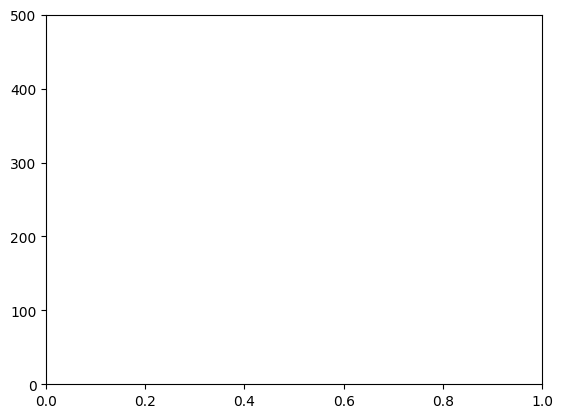

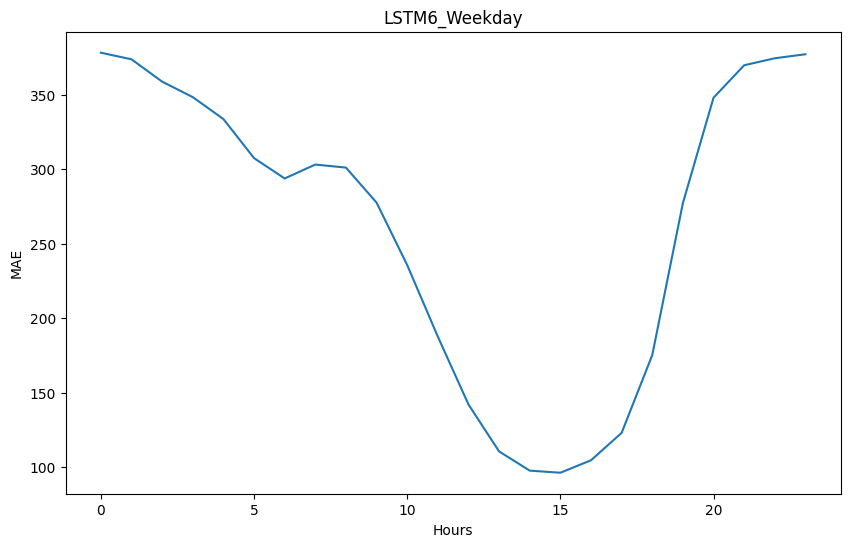

In [ ]:
Hours = [i for i in range(24)]
plt.ylim(0, 500)
plt.figure(figsize=(10,6))
plt.plot(Hours, MAE_results)
plt.xlabel("Hours")
plt.ylabel("MAE")
plt.title("LSTM6_Weekday")

Text(0.5, 1.0, 'LSTM6_Weekend')

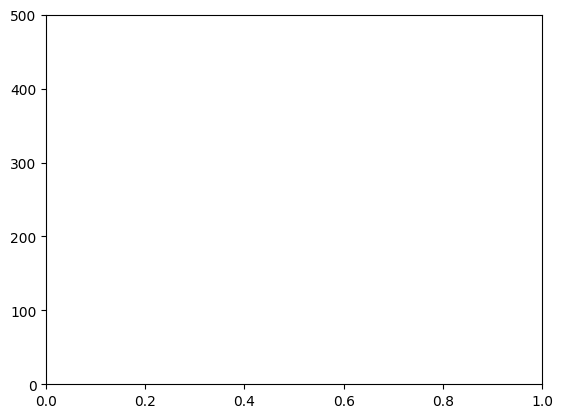

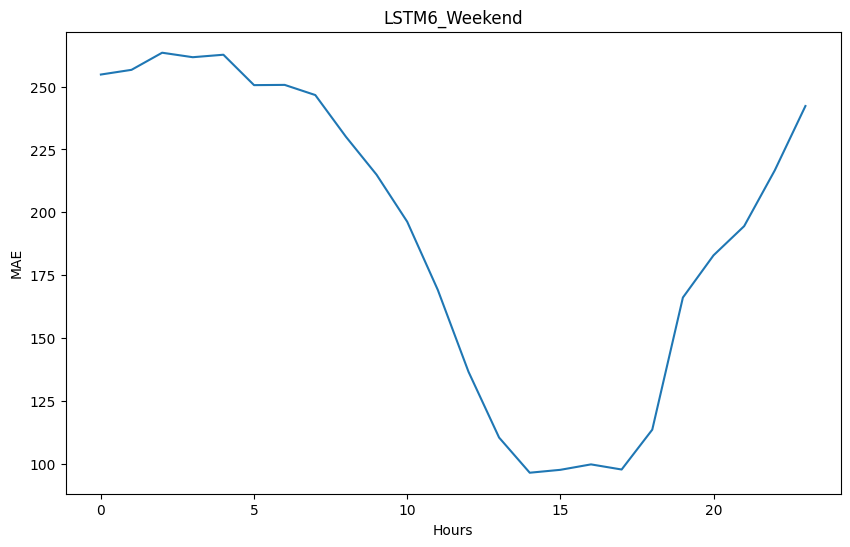

In [ ]:
plt.ylim(0, 500)
plt.figure(figsize=(10,6))
plt.plot(Hours, MAE_results2)
plt.xlabel("Hours")
plt.ylabel("MAE")
plt.title("LSTM6_Weekend")